In [1]:
import snowflake as sf 
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt 
from sqlalchemy import create_engine
from pandas_profiling import ProfileReport
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings("ignore")

C:\Users\amtre\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### 1. Fetch data from Snowflake

In [2]:
# Establish connection
engine = create_engine(
  'snowflake://{user}:{password}@{account}/'.format(
    user = '',
    password = '',
    account = '',
  )
)

# Try connection
try:
    connection = engine.connect()
    print('Succesfuly connected to Snowflake')
except:
    print('Connection failed, check credentials')
    
# Set a cursor
con = sf.connector.connect(user = '',
                           password = '',
                           account = '',
                           warehouse='',
                           database='',
                           schema=''
                           )
sfq = con.cursor()
print('Establish connection to snowflake is succesful')


# Function to fetch results as pandas dataframe 
def fetch_results(connection, query:str):
    connection.execute(query)
    return connection.fetch_pandas_all()

Succesfuly connected to Snowflake
Establish connection to snowflake is succesful


In [3]:
# Fetch results according to query
query1 = '''SELECT DISTINCT TD.STATE, T.CLIENT_ID, MD."status" AS CLIENT_STATUS, MD.INDUSTRY AS CLIENT_INDUSTRY, T.RECEIPT_NO, TD.STATUS_CODE TRANSACTION_STATUS_CODE, TD.IS_CHARGEBACK, CD.CARD_TYPE, CD.ISSUER, CD.COUNTRY_CODE, T.READER_ID, RD.READER_TYPE, T.CREATED_AT, T.AMOUNT FROM (SELECT * FROM TRANSACTIONS WHERE CLIENT_ID IN (SELECT DISTINCT(CLIENT_ID) FROM MERCHANT_DETAIL WHERE EXTRACT(YEAR FROM ONBOARDING_DATE) = 2017 AND EXTRACT(MONTH FROM ONBOARDING_DATE) = 1) AND EXTRACT(YEAR FROM CREATED_AT) = 2017) T INNER JOIN TRANSACTION_DETAIL TD USING (RECEIPT_NO) INNER JOIN CARD_DETAIL CD ON TD.RECEIPT_NO = CD.RECEIPT_NO INNER JOIN READER_DETAIL RD ON T.READER_ID = RD.READER_ID INNER JOIN MERCHANT_DETAIL MD ON T.CLIENT_ID = MD.CLIENT_ID'''
q_1 = fetch_results(sfq, query1)
print('Retrieved data is succesful')

Retrieved data is succesful


### 2. Basic EDA

`query1` brings all the information of the transactions for the year 2017 for those users that started on January 2017. The relevant features are:

* `CLIENT_STATUS`. The actual status of the user.
* `CLIENT_INDUSTRY`. The industry to which the user belongs.
* `TRANSACTION_STATUS_CODE`. The status of the transaction where 1 indicates a valid transaction.
* `IS_CHARGEBACK`. Binary value that indicates wheter or not the transaction is a chargeback.
* `CARD_TYPE`. Type of the card, for example, debit or credit.
* `ISSUER`. The bank to which the card belongs to. 
* `READER_TYPE`. The name of the clip device used in that transaction.

In order to get a first general idea of the variables let's use the `Profile Report` function from the `pandas profiling` package, which allow us to see the distribution of each variable, missing values, interactions and correlations between them. Then, as some details seem interesting to us we're going to get deeper into each one of this details. 

In [4]:
profile = ProfileReport(q_1, title='Basic Report of variables', html={'style':{'full_width':True}})

In [5]:
profile.to_widgets()

Let's interpret one by one the output of each section. 

### A. Overview-Warnings 

* **Missing**. Three columns `CARD_TYPE`, `ISSUER` and `COUNTRY_CODE` have less than 3% missing values. These variables come from the information of the card. `CARD_TYPE` appears to be the most relevant to take into consideration of the three to drop information because it allows us to gain insights like `it is more likely to stop using the CLIP device if the user got transactions from credit cards`.  

* **High Cardinality**. It is highly possible that we need to group countries by continents or `ISSUER` by a major category. 


### B. Variables

We notice the following facts:

* <span style="color:blue"> Most of the transactions come from the state with code 09 and 15. </span>

* The **top client** is `7aff077912...`.

* <span style="color:blue"> Most of the users are active. </span>

* **Transactions** tend to **come from `Alimentos y Bebidas` and `Tiendas y público en general`**. It could be assumed that in general these are small and medium business because stores and restaurants like `Vips` or `Liverpool` have a terminal affiliated with a Bank. We'll further clarify this. 

* <span style="color:blue"> Most of the transactions come from `DEBIT` cards. </span> These is highly interesting because getting a credit has some requirements or limitations that debit cards do not have. For example, consider how easy is for a person to get a card issued from Oxxo or MercadoLibre (Prepaid debit cards).

* The main issuers are top banks in Mexico like Bancomer, Banamex or Santander. It should be interesting to investigate what are the basic requirements for a person to get a debit card from this banks in order to further develop the inquiry of the last point. 

* <span style="color:blue"> Most of the transactions are local (Mexico). </span>

* Frequent transactions come from the `CLASSIC` device, this is the simple version of the CLIP devices. We could hypothize the following there is no competitive advantage for the user to make a trade-off between price and functionality of the device.

* <span style="color:blue"> The average ticket is nearly 1000 pesos, but the median is 200 pesos. </span> Therefore it seems that most of the users make transactions related to products or actions of first need,for example, if I go to a cornershop and I don't bring cash or I go to eat to a fonda. But we'll need to prove or reject this assumption.


#### C. Correlations

The pearson correlation between `AMOUNT` and `IS_CHARGEBACK` is slightly positive, that is, when a chargeback occurs tends to be of a greater amount than when it doesn't occur. However, the spearman coefficient is close to cero, therefore we could not affirm that it necessarily increases the amount when a chargeback happens, further investigation is needed.  


#### D. Missing Values

* The heatmap is showing us the **nullity correlation**. In this case, when `CARD_TYPE` is missing information, also the `ISSUER` and the `COUNTRY_CODE`. In fact, this are variables of the `CARD_DETAIL` table.

* The dendogram allow us to correlate variable completion. In this case `ISSUER` predicts the missingness of information of `COUNTRY_CODE`, when one is missing so is the other one.   

In [6]:
# Automatic coverstion of variable types
q_1 = q_1.convert_dtypes()


# Fix CARD_TYPE variable
q_1.CARD_TYPE = q_1.CARD_TYPE.astype(str).replace({'Debit':'DEBIT',
                                                   'D':'DEBIT',
                                                   'Credit':'CREDIT',
                                                   'C':'CREDIT',
                                                   'P':'PREPAID',
                                                   ' ':'<NA>'})

# Filter by Payment status 1,3 and -3
status = [1, 3, -3]
q_1 = q_1[q_1.TRANSACTION_STATUS_CODE.isin(status)]

# Filter N/A values of READER_TYPE (~3920)
q_1 = q_1[q_1.READER_TYPE != 'N/A']

# Filter <NA> values of CARD_TYPE (~39620)
q_1 = q_1[q_1.CARD_TYPE != '<NA>']

### 3. Marginal distribution of Amount and Joint Relationships

In [7]:
# Distribution of Amount
print(q_1.AMOUNT.describe(),
      "\n",
      f"The 5th percentile is {q_1.AMOUNT.quantile(.05)}",
      "\n",
      f"The 90th percentile is {q_1.AMOUNT.quantile(.9)}",
      "\n",
      f"The 95th percentile is {q_1.AMOUNT.quantile(.95)}",
      "\n",
      f"The 98th percentil is {q_1.AMOUNT.quantile(.98)}",
      f"The kurtosis is {kurtosis(q_1.AMOUNT)}",
      " \n",
      f"The skewness is {skew(q_1.AMOUNT)}")

count    618147.000000
mean        904.798435
std        3086.619504
min           0.010000
25%          65.000000
50%         200.000000
75%         620.000000
max       99999.000000
Name: AMOUNT, dtype: float64 
 The 5th percentile is 18.0 
 The 90th percentile is 1755.0 
 The 95th percentile is 3500.0 
 The 98th percentil is 8000.0 The kurtosis is 212.8153061777966  
 The skewness is 11.633343541276105


In [8]:
# Filter data by amount values less than threshold
q_1_a = q_1[(q_1.AMOUNT > 1) & (q_1.AMOUNT < 8000)]

# Log transform of amount
q_1_a['log_AMOUNT'] = np.log(q_1_a.AMOUNT)

print(q_1_a.shape)

(595925, 15)


#### A. Density plot of amount vs variables

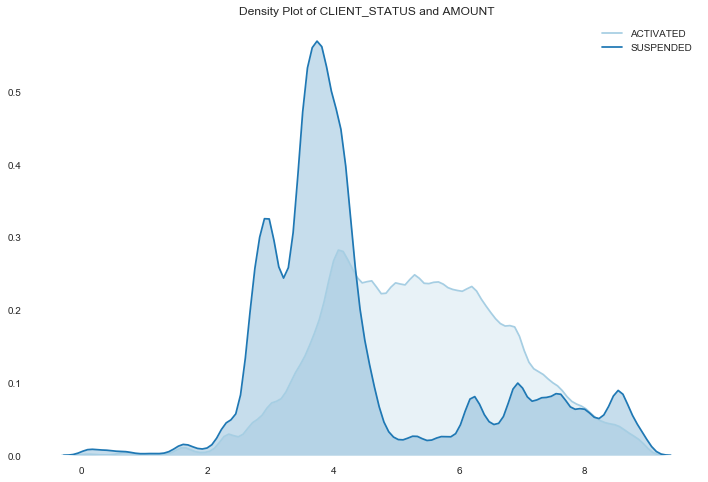

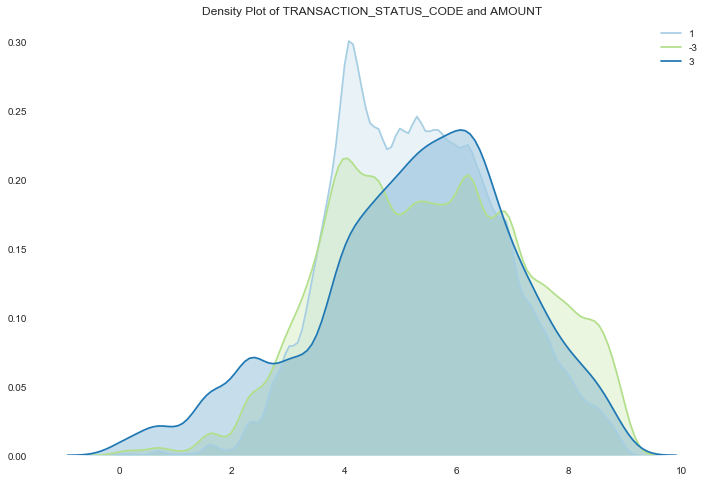

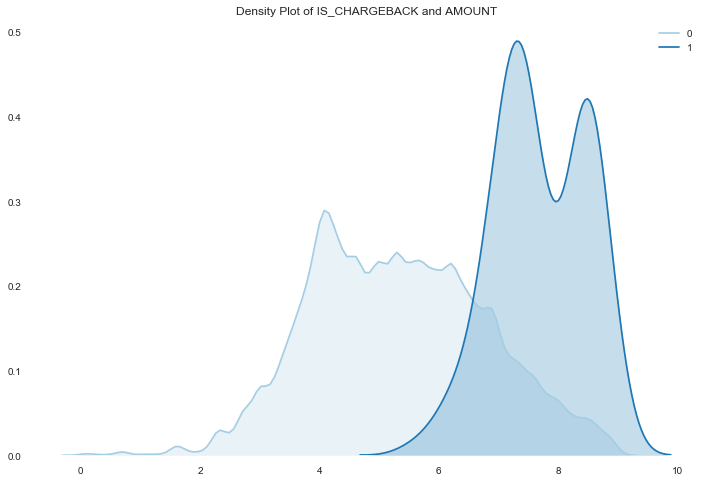

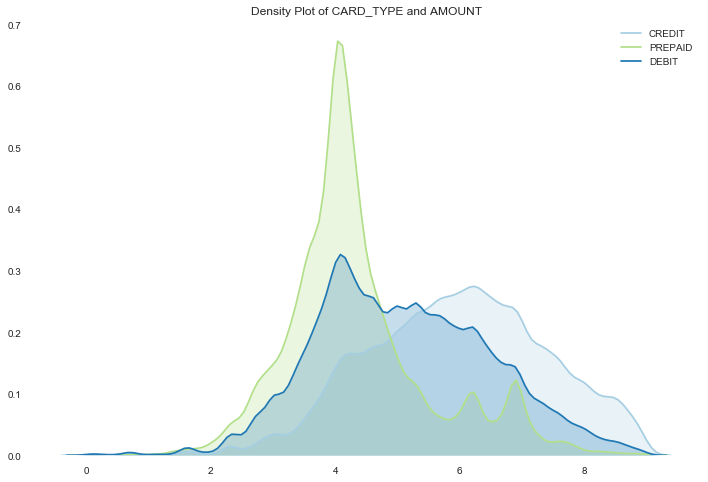

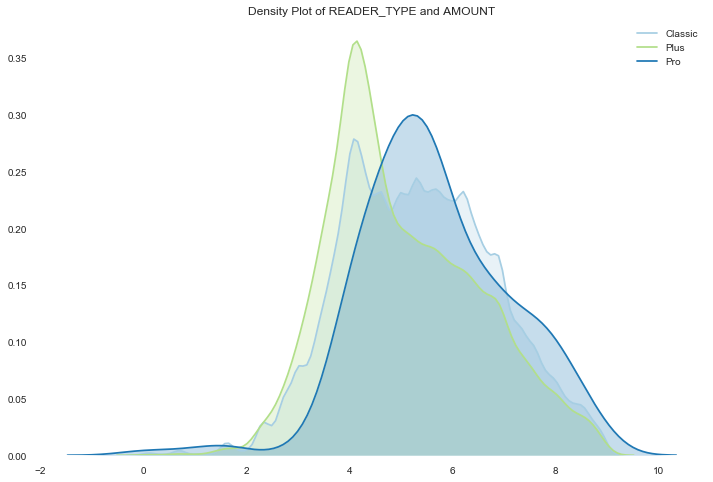

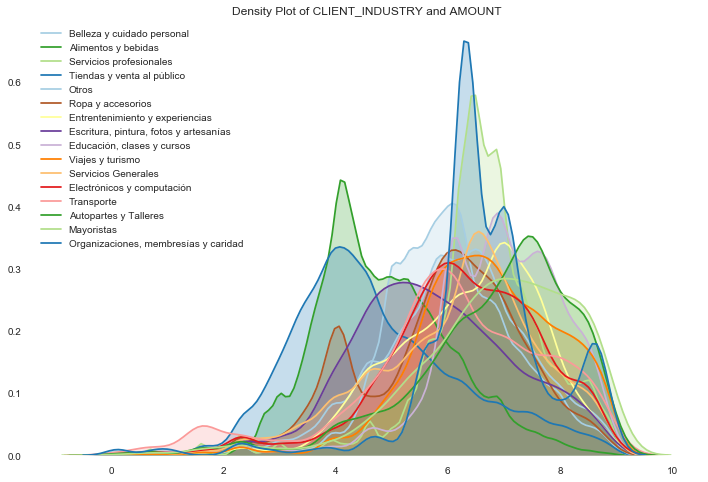

In [9]:
# Function to plot a density of amount by category
def amount_category(df:'pd.DataFrame', col:str):
    
    # Categories
    cgs = df[col].unique()
    num = len(cgs)
    
    # Subcategories by amount
    iterables = ((v,'log_AMOUNT') for v in cgs)
    
    # Define a color palette and plot figuresize
    palette = sns.color_palette("Paired", num)
    plt.figure(figsize = (12,8))
    
    # Plot a density plot for every subcategory 
    for i, e in enumerate(iterables):
        x, y = e
        sns.kdeplot(df.loc[df[col]==x,y], shade=True, color=palette[-i], label=x)
    
    plt.title(f"Density Plot of {col} and AMOUNT")
    plt.show()

    
categories = ['CLIENT_STATUS','TRANSACTION_STATUS_CODE','IS_CHARGEBACK', 'CARD_TYPE', 'READER_TYPE', 'CLIENT_INDUSTRY']

for c in categories:
    amount_category(q_1_a, c)

#### B. Violin plot of amount vs variables

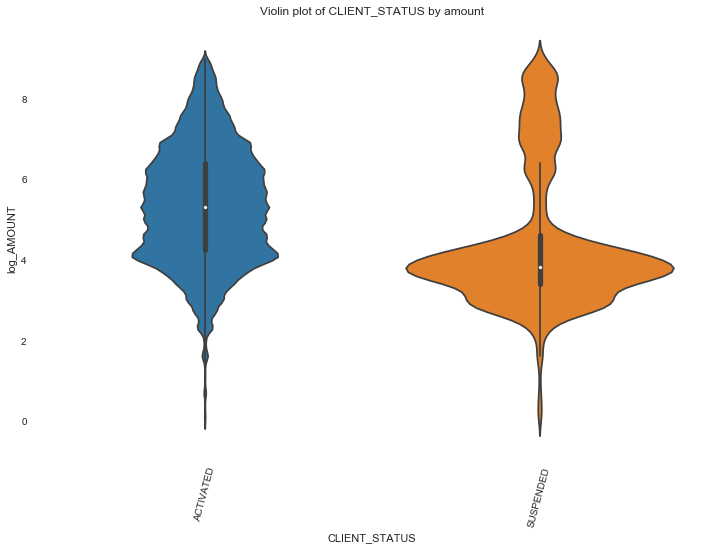

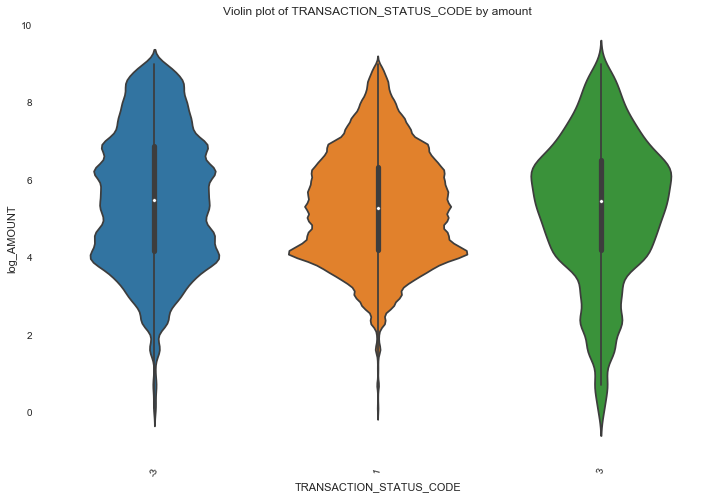

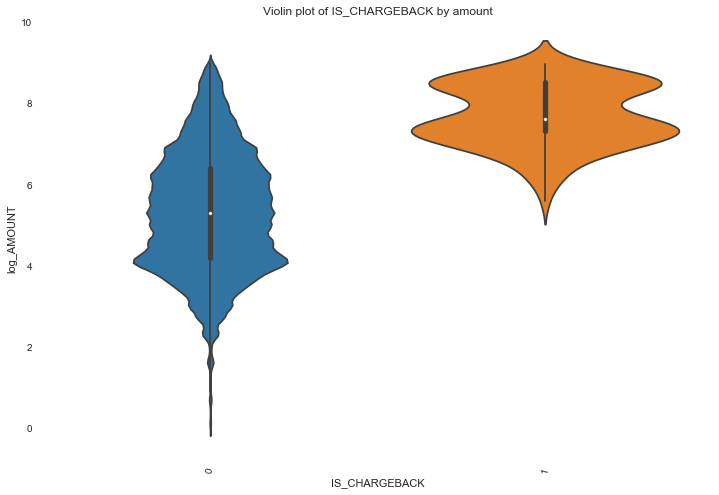

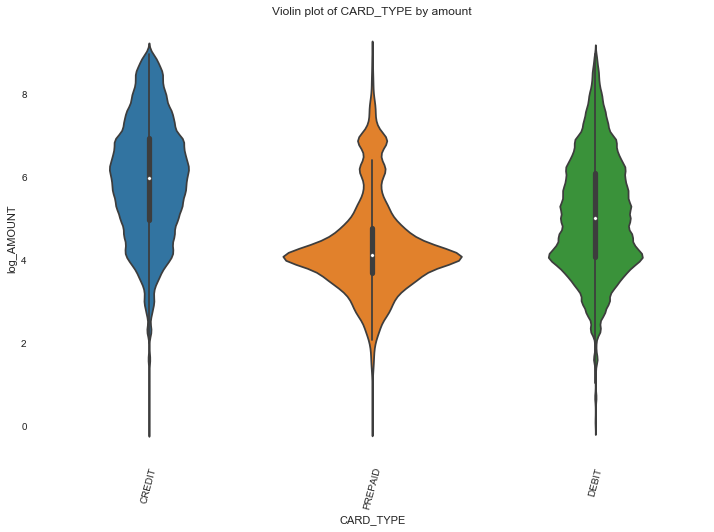

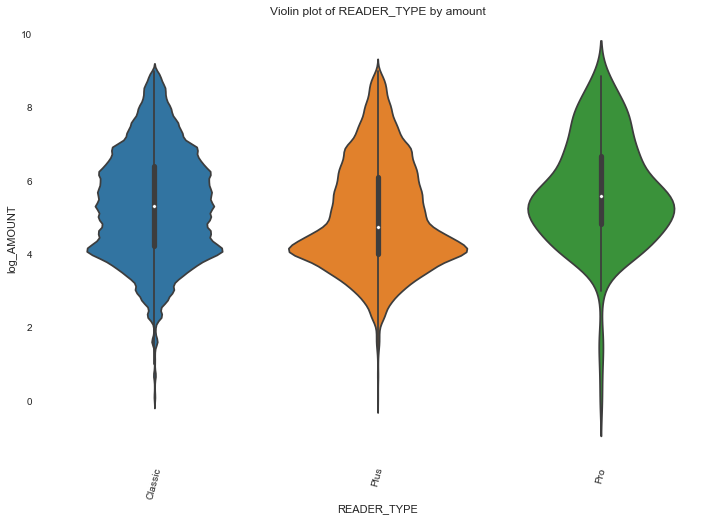

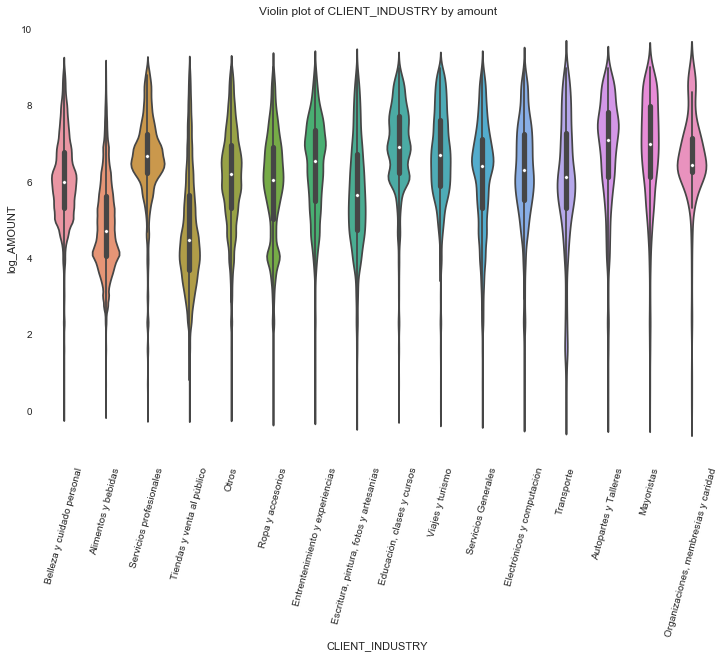

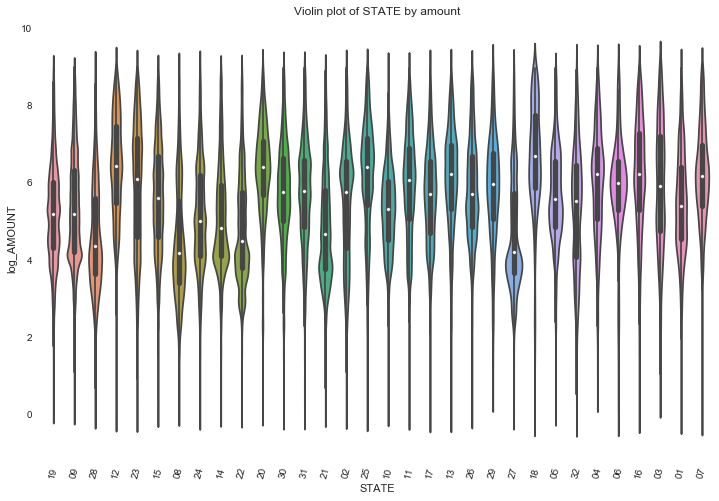

In [10]:
categories = ['CLIENT_STATUS','TRANSACTION_STATUS_CODE','IS_CHARGEBACK', 'CARD_TYPE', 'READER_TYPE', 'CLIENT_INDUSTRY', 'STATE']


for i, var in enumerate(categories):
    plt.figure(figsize=(12, 8))
    sns.violinplot(x=q_1_a[var], y=q_1_a['log_AMOUNT'])
    plt.xticks(rotation=75)
    plt.title(f"Violin plot of {var} by amount")
    plt.show()

Of what we have stated before we can confirm that: 

1. Chargebacks are of greater amount in average than non-chargebacks.

2. Most of the users make transactions related to products or services of first need. In the violinplot the `white point` represents the median of the data. Thus, for `Alimentos y bebidas`, `Tiendas y Venta al público`, `Transporte` y `Escriture, pintura, fotos y artesanías` the median ticket is below 250 pesos approximately. 

3. There is no competitive advantage for the user to make a trade-off between price and functionality of the device. This is partially true, we can see that the `Pro` users have a more flat distribution with it's peak value slightly to the right compared to the `Classic` and `Plus` users. In fact, the `Pro` users have a higher average ticket, but we would need to understand this by industry. For example, the violin plot for `Professional Services`, `Educación, clases y cursos` and `Organizaciones, membresías y caridad` are top median ticket. Thus a dentist and a yoga teacher could afford this trade-off.              

4. Most of the transactions come from `DEBIT` cards. Even though that's true, there is an interesting behavior for those `PREPAID` users. That is, `PREPAID` transactions tend to be of low amount. In other words, the utility live of this type of payment is lower. It is thus interesting to further investigate which type of users tend to use this payment method. 


Furthermore, there are also some interesting fact that we see in the plots:

1. The median ticket across states is heterogeneous. 

2. `Cancelled` amounts are slightly smaller than `Approved` or `Declined`. This is very interesting because there appears to be a behavior relationship with the action of the user. For example, consider paying one gansito (10 pesos or 40 cents of dollar) with card, then it is probable that the user cancels this transaction if he remembers that he has coins in his pockets. 

3. `SUSPENDED` accounts pay less on a transaction. Most of the amounts are concentrated between 0 and 100 pesos by transaction, whereas active accounts have a tail that is exponentially diminishing until it gets to nearl 1000 pesos.

Our next step is to visually study these interactions between industry, for example transactions by chargeback and Industry type. 

#### C. Visualizations across industry types

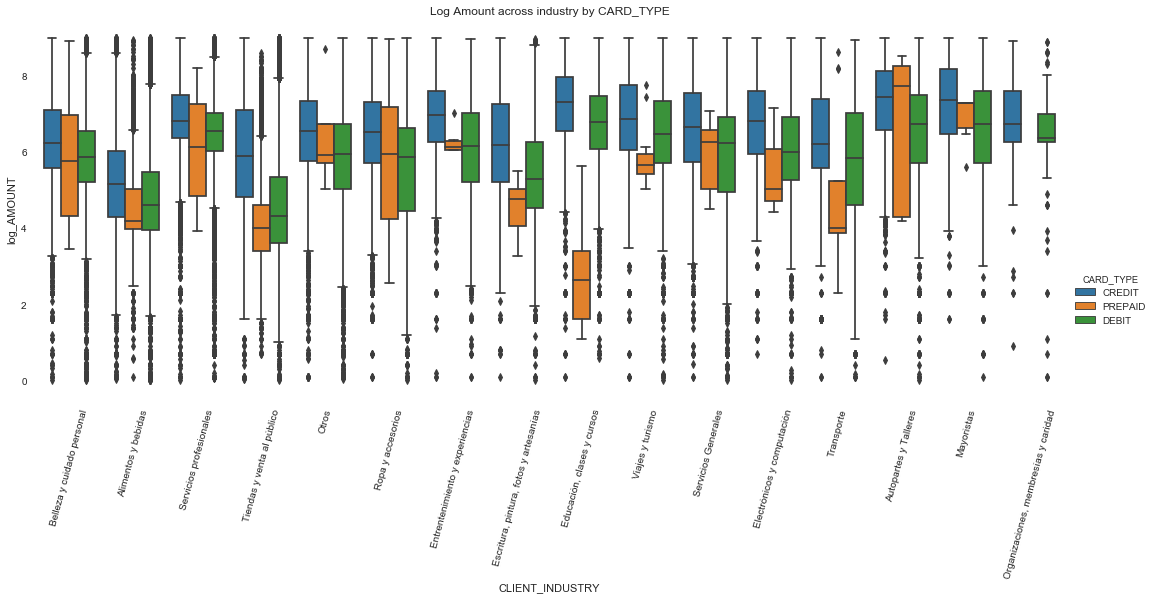

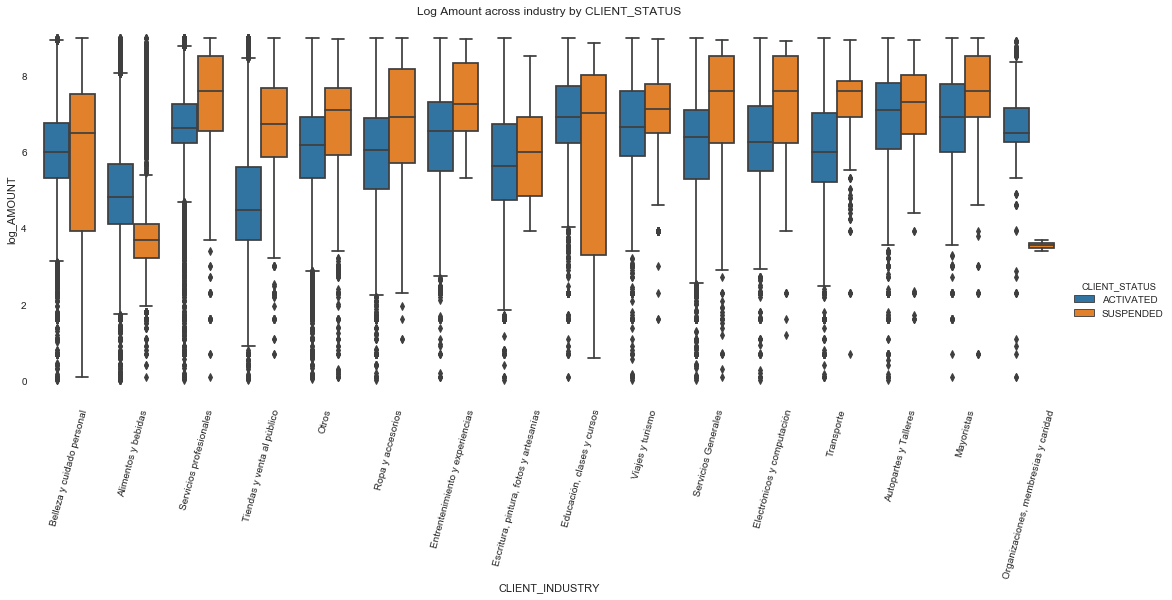

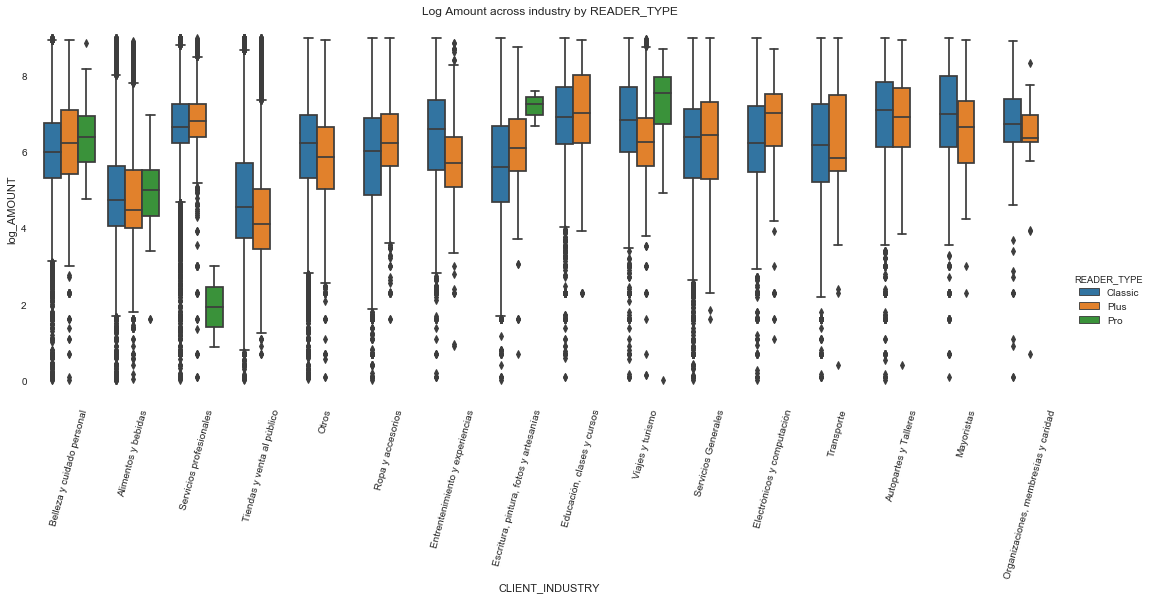

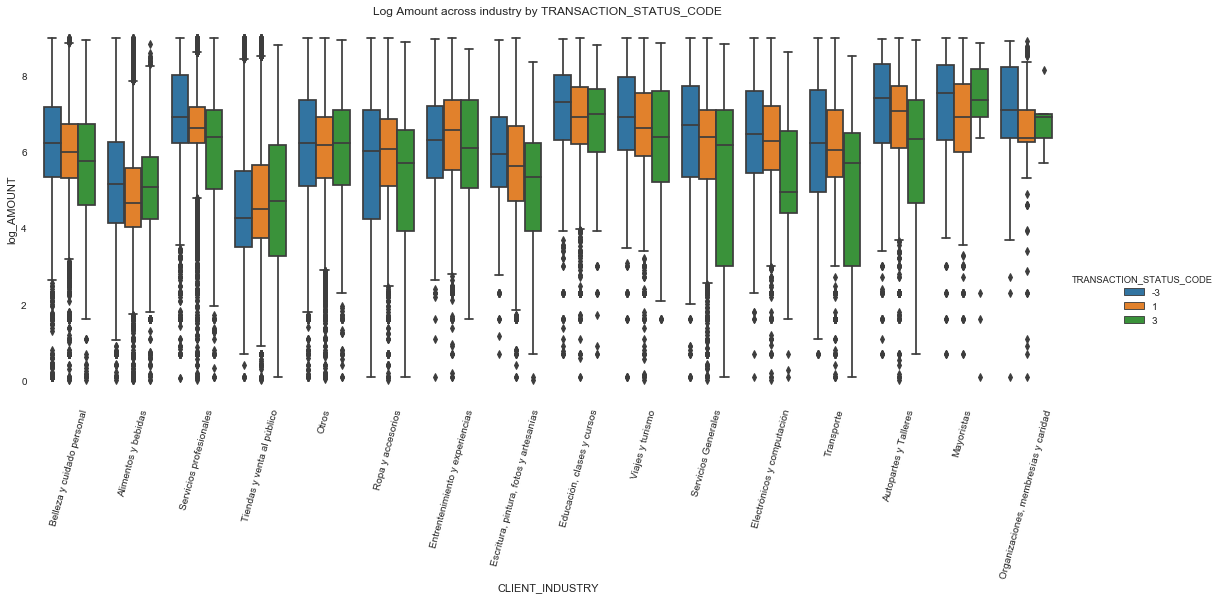

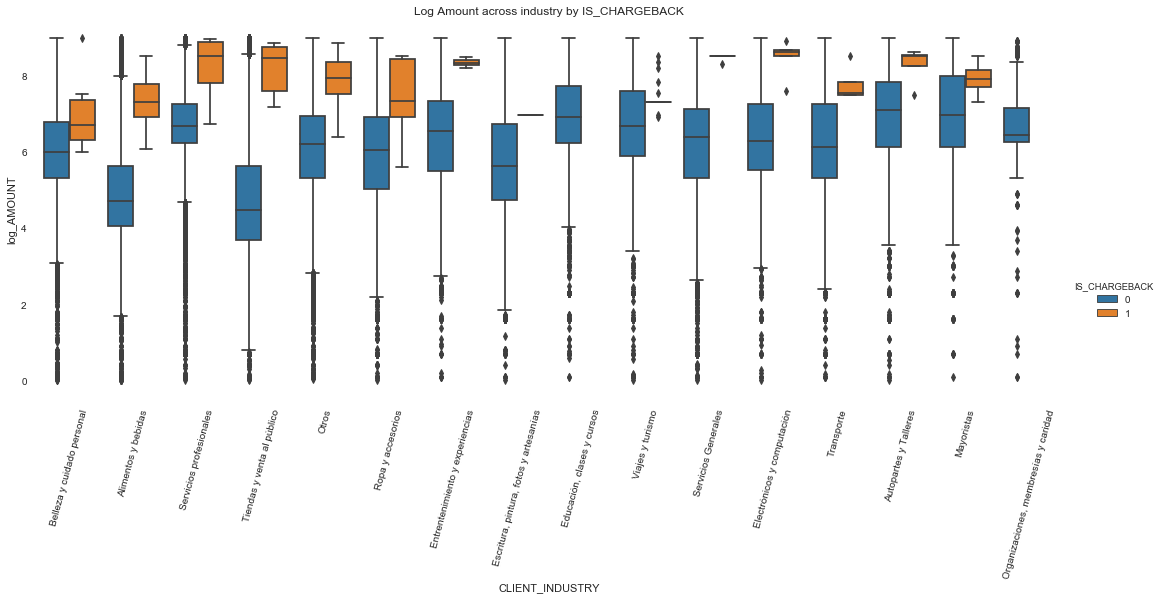

In [11]:
#plt.figure(figsize=(16,12))

cols = ['CARD_TYPE', 'CLIENT_STATUS', 'READER_TYPE', 'TRANSACTION_STATUS_CODE', 'IS_CHARGEBACK']

for c in cols:
    sns.catplot(x="CLIENT_INDUSTRY", 
                y="log_AMOUNT", 
                hue=c, 
                data=q_1_a, 
                kind="box",
                height=6,
                aspect=2.5)
    plt.xticks(rotation=75)
    plt.title(f"Log Amount across industry by {c}")
    plt.show()

* The median for credit card transactions is higher than debit and prepaid. 

* We've seen before that the amount for `SUSPENDED` clients was more concentrated on lower amounts. Now, as we're considering it by industry we notice that the median for `SUSPENDED` clients is higher than `ACTIVE` clients except for `Alimentos y Bebidas`.

* The `Pro` device is not used across all industries like `Ropa y Accesorios`, `Entretenimiento y Experiencias`, `Educación, clases y otros` or `Transporte`. However, the minimum value for the transaction is higher than other reader types (except for Servicios Profesionales), consider `Belleza y cuidado personal` as example.

#### D. Visualization across time by industry

In [12]:
# Add year and month variable
q_1_a['Year'] = q_1_a.CREATED_AT.dt.year
q_1_a['Month'] = q_1_a.CREATED_AT.dt.month

def industry_by_category_in_time(dt:'pd.DataFrame', col:str, function:str):

    dt = dt.groupby(['Year', 'Month', 'CLIENT_INDUSTRY']) \
           .agg({col:function}) \
           .reset_index() \
           .sort_values(by=['Year','Month'])

    plt.figure(figsize=(12,10))
    plt.style.use('ggplot')
    
    for industry in dt.CLIENT_INDUSTRY.unique():
        f = np.where(dt.CLIENT_INDUSTRY == industry)
        df = dt.iloc[f]
        plt.plot(df.Month, df[col], label=industry)
        plt.annotate(industry, (1, max(df[col])), fontsize='small')
        plt.legend(loc='upper right')
    
    plt.xlabel("Month")
    plt.ylabel("Users")
    plt.title(f"{col} by industry for the year 2017")
    plt.show()

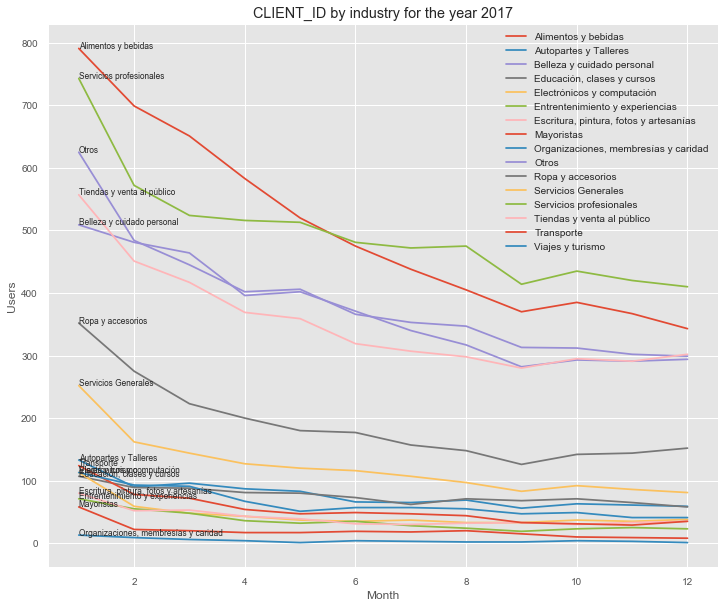

In [13]:
# Users in industry by category
industry_by_category_in_time(q_1_a,'CLIENT_ID','nunique')

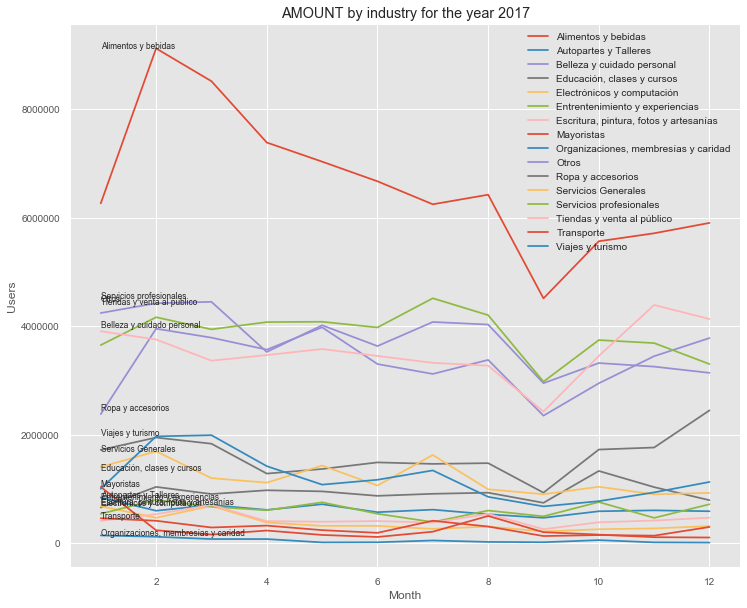

In [14]:
industry_by_category_in_time(q_1_a,'AMOUNT','sum')

In [15]:
def industry_by_category_in_time(dt:'pd.DataFrame', cat:str, col:str, function:str):

    dt = dt.groupby(['Year', 'Month', 'CLIENT_INDUSTRY',cat]) \
           .agg({col:function}) \
           .reset_index() \
           .sort_values(by=['Year','Month'])
    
    rows, cols = len(dt.CLIENT_INDUSTRY.unique()),len(dt[cat].unique())
    iterables = [(ind,category) for ind in dt.CLIENT_INDUSTRY.unique() for category in dt[cat].unique()]
    
    plt.figure(figsize=(12, 24))
    for idx,value in enumerate(iterables):
        industry, category = value
        plt.subplot(rows,cols,idx+1)
        f = np.where((dt.CLIENT_INDUSTRY == industry) & (dt[cat] == category))
        df = dt.iloc[f]
        plt.plot(df.Month, df[col], label=category, c='b')
        plt.grid(False)
        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False) #
        plt.title(f"{col} of {industry} for the year 2017", fontsize="small")
        plt.legend(loc='upper right')
    
    plt.show()

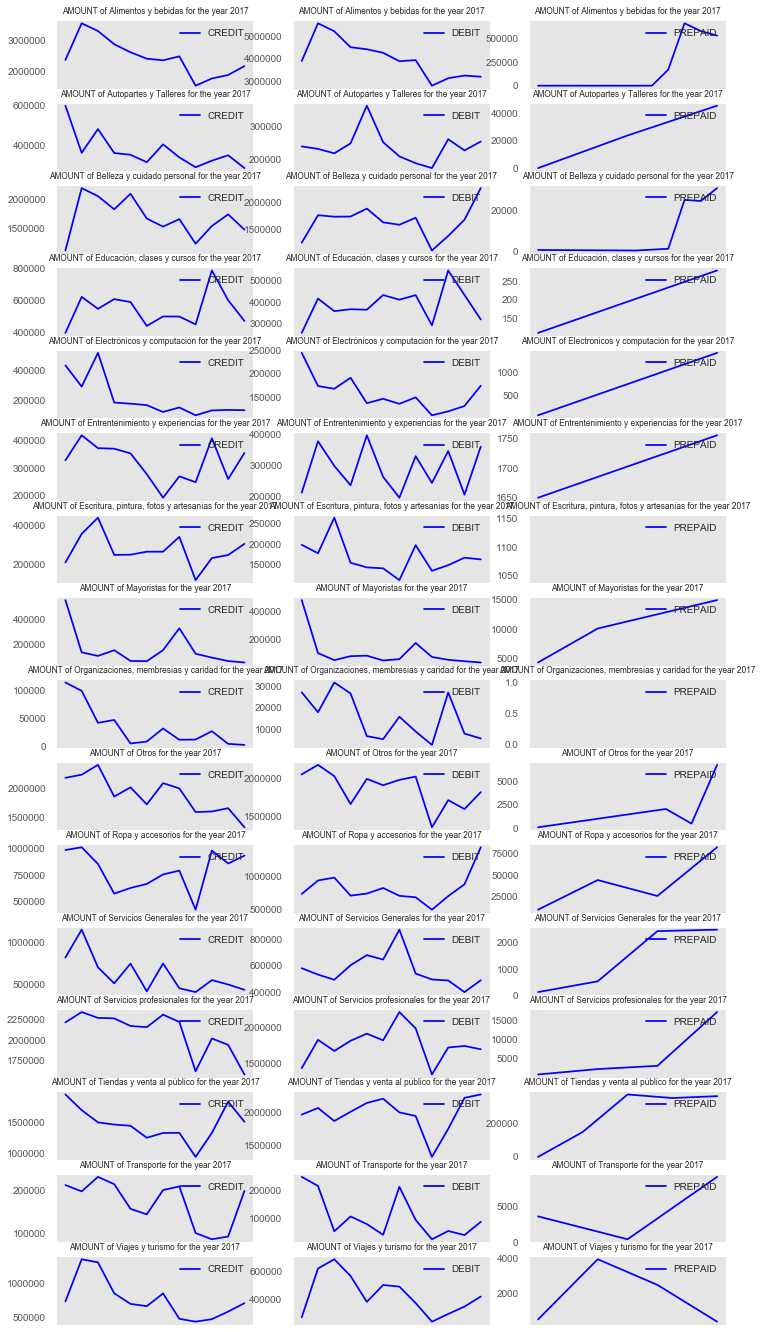

In [16]:
# Amount by card type by industry across time
industry_by_category_in_time(q_1_a, 'CARD_TYPE', 'AMOUNT', 'sum')

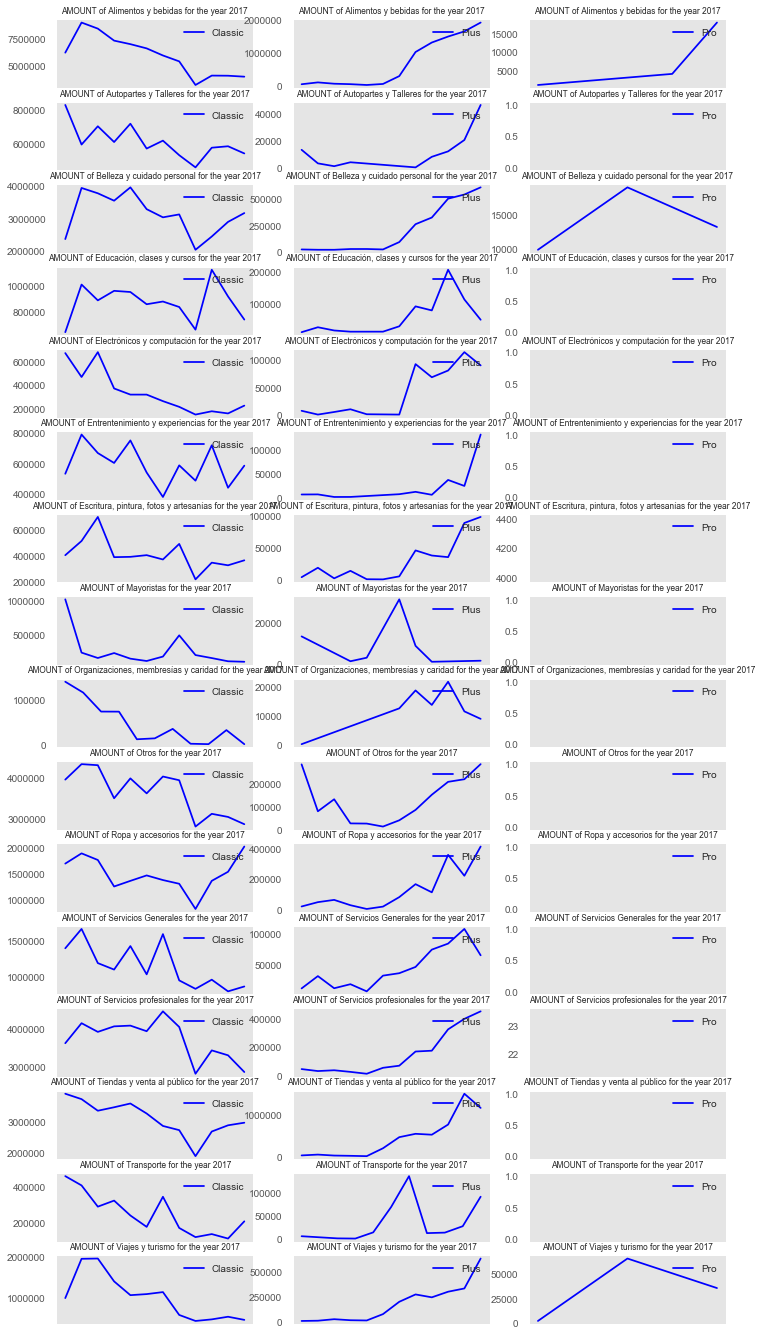

In [17]:
# Amount by reader type by industry across time
industry_by_category_in_time(q_1_a, 'READER_TYPE', 'AMOUNT', 'sum')

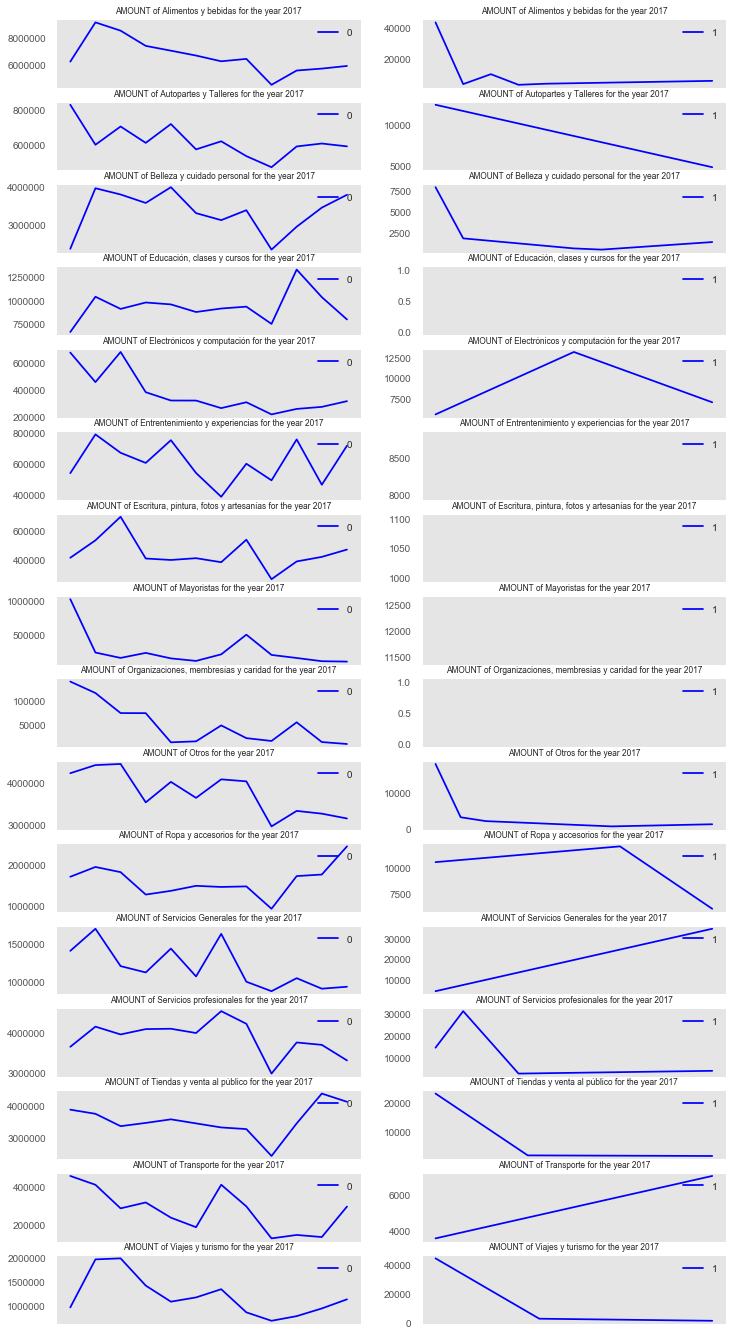

In [18]:
# Amount by chargeback by industry across time
industry_by_category_in_time(q_1_a, 'IS_CHARGEBACK', 'AMOUNT', 'sum')

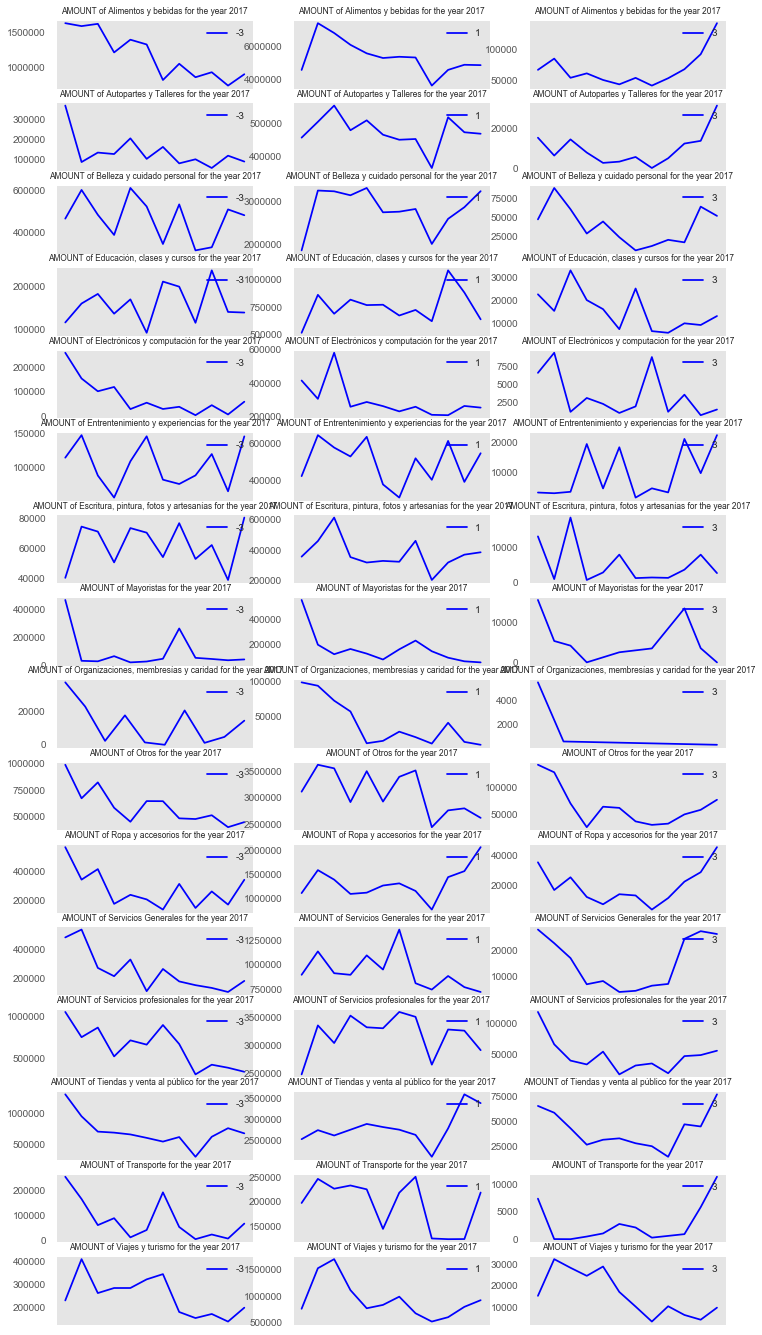

In [19]:
# Amount by Transaction status code by industry across time
industry_by_category_in_time(q_1_a, 'TRANSACTION_STATUS_CODE', 'AMOUNT', 'sum')

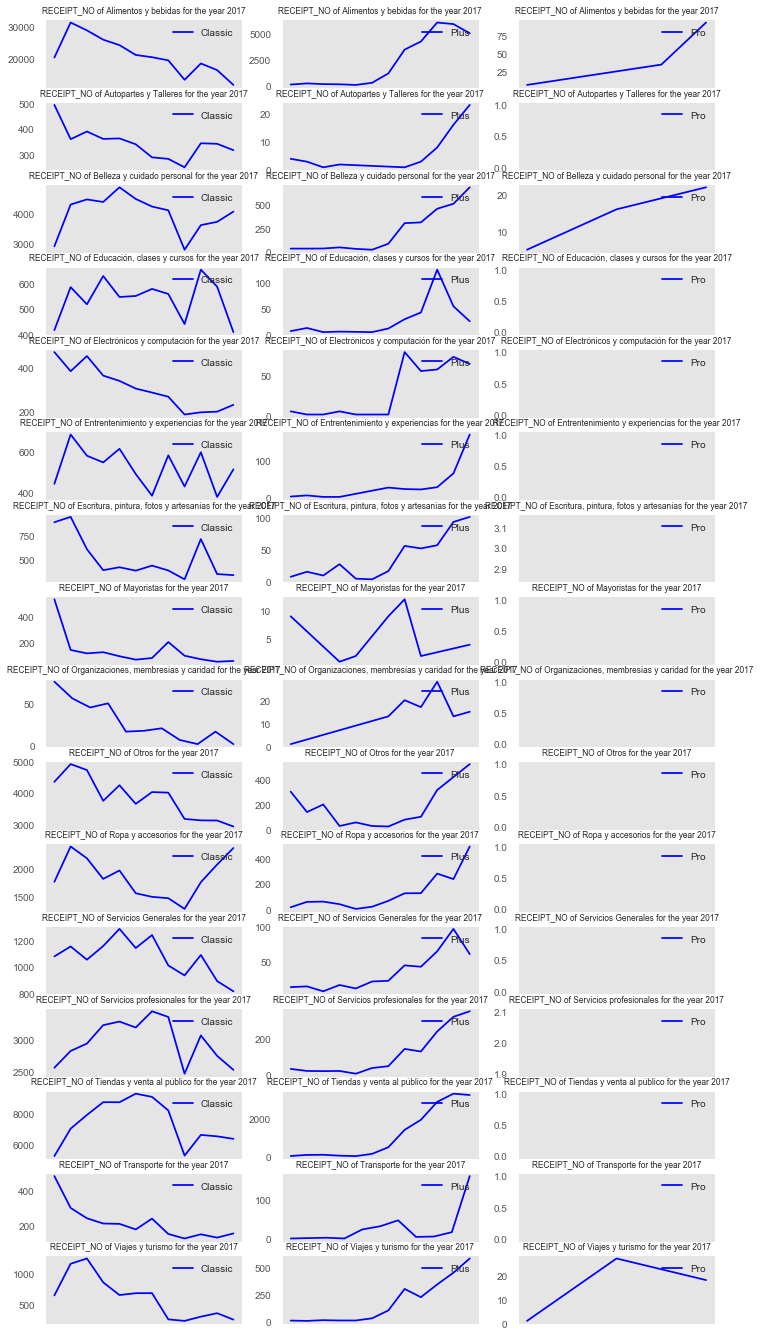

In [20]:
# Transactions of each reader type by industry across time
industry_by_category_in_time(q_1_a, 'READER_TYPE', 'RECEIPT_NO', 'nunique')

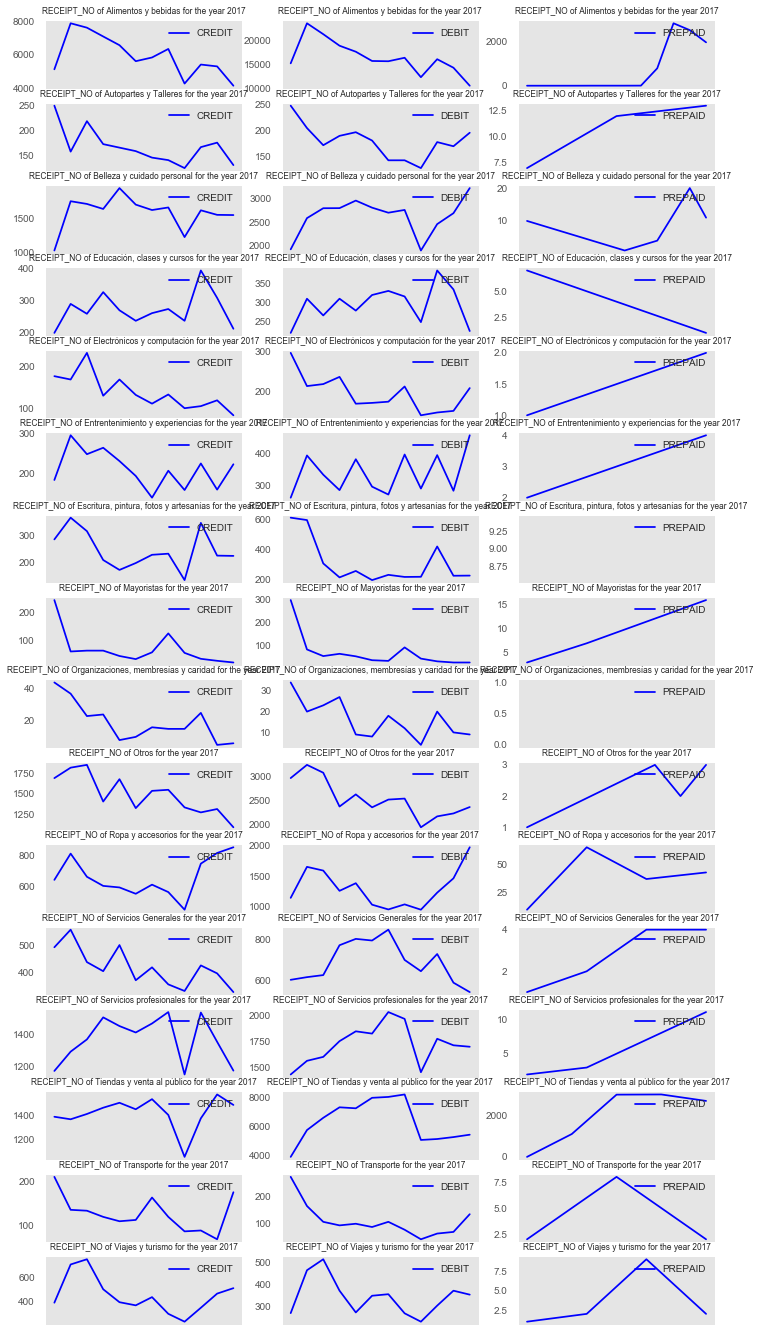

In [21]:
# Transactions of each card type by industry across time
industry_by_category_in_time(q_1_a, 'CARD_TYPE', 'RECEIPT_NO', 'nunique')